In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests as req
import os
import gmaps
from citipy import citipy
from datetime import datetime
from config import weather_api_key
from config import g_key
from scipy.stats import linregress

In [2]:
def build_url(city):
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    return base_url + "units=Imperial" + "&APPID=" + weather_api_key + "&q=" + city

In [3]:
url = "http://api.openweathermap.org/data/2.5/weather?" + "units=Imperial" + "&APPID=" + weather_api_key

In [4]:
cities = ["Pittsburgh", "Austin", "New  York", "Los Angeles", "Seattle"]
for city in cities:
    try:
        city_url = url + "&q=" + city
        weather = req.get(city_url).json()
        temp = weather['main']['temp']
    except KeyError:
        print("KeyError received for " + city)
        continue
    print("It is currently " + str(temp) + " degrees in " + city)

        

It is currently 72.36 degrees in Pittsburgh
It is currently 81.57 degrees in Austin
KeyError received for New  York
It is currently 71.06 degrees in Los Angeles
It is currently 46.67 degrees in Seattle


# Create zipped lat_lngs[] with 1500 random lat & lon values

In [5]:
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)
lat_lngs

# create coordinates[] from zipped lat_lngs[]

In [6]:
coordinates = list(lat_lngs)

# Use citipy to find nearest_city for coordinates[] and append to cities[]

In [7]:
cities = []
for coordinate in coordinates:
    x = coordinate[0]
    y = coordinate[1]
    city_name    = citipy.nearest_city(coordinate[0], coordinate[1]).city_name
    country_code = citipy.nearest_city(coordinate[0], coordinate[1]).country_code
    #print(f"{x} {y} {city_name} {country_code}")
    if city_name not in cities:
        cities.append(city_name)
print(len(cities))

599


# Append rows to city_data[] for each city

In [8]:
def get_cities_from_weatherfoo():
    city_data = []
    print("Beginning Data Retrieval     ")
    print("-----------------------------")
    record_count = 1
    set_count = 1
    
    for i, city in enumerate(cities):

        # Group cities in sets of 50 for logging purposes.
        if (i % 50 == 0 and i >= 50):
            set_count += 1
            record_count = 1
        # Create endpoint URL with each city.
        city_url = url + "&q=" + city.replace(" ","+")
        #print(city_url)

        # Log the URL, record, and set numbers and the city.
        print(f"Processing Record {record_count} of Set {set_count} | {city}")
        # Add 1 to the record count.
        record_count += 1
    
        # Run an API request for each of the cities.
        try:
            # Parse the JSON and retrieve data.
            city_weather = req.get(city_url).json()
            # Parse out the needed data.
            city_lat = city_weather["coord"]["lat"]
            city_lng = city_weather["coord"]["lon"]
            city_max_temp = city_weather["main"]["temp_max"]
            city_humidity = city_weather["main"]["humidity"]
            city_clouds = city_weather["clouds"]["all"]
            city_wind = city_weather["wind"]["speed"]
            city_country = city_weather["sys"]["country"]
            # Convert the date to ISO standard.
            city_date = datetime.utcfromtimestamp(city_weather["dt"]).strftime('%Y-%m-%d %H:%M:%S')
            # Append the city information into city_data list.
            city_data.append({"City": city.title(),
                          "Lat": city_lat,
                          "Lng": city_lng,
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

            #print("city="+city
            #      +", lat="+str(city_weather['coord']['lat'])
            #      +", lon="+str(city_weather['coord']['lon']))  

        # If an error is experienced, skip the city.
        except:
            print("City not found. Skipping...")
            pass

    print("-----------------------------")
    print("Data Retrieval Complete      ")
    print("-----------------------------")

# Create city_data_df DataFrame

In [9]:
if os.path.isfile("weather_data/cities.csv"):
    city_data_df = pd.read_csv("weather_data/cities.csv")
else:
    get_cities_from_weatherfoo()
    city_data_df = pd.DataFrame(city_data)
    
city_data_df.head(10)

,City_ID,City,Country,Date,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed
0,0,Saint George,US,2021-04-07 23:35:39,37.1041,-113.5841,81.00,7,1,4.61
1,1,Tura,IN,2021-04-07 23:37:06,25.5198,90.2201,67.03,81,0,5.64
2,2,Kapaa,US,2021-04-07 23:35:16,22.0752,-159.3190,77.00,65,75,21.85
3,3,Galeana,MX,2021-04-07 23:39:22,24.8333,-100.0667,82.99,16,59,8.01
4,4,Turukhansk,RU,2021-04-07 23:39:23,65.8167,87.9833,28.96,98,100,3.36
5,5,Baykit,RU,2021-04-07 23:39:23,61.6700,96.3700,28.96,93,95,3.71
6,6,Esperance,AU,2021-04-07 23:39:23,-33.8667,121.9000,60.80,100,75,3.44
7,7,Rikitea,PF,2021-04-07 23:39:24,-23.1203,-134.9692,77.02,61,0,8.46
8,8,Olafsvik,IS,2021-04-07 23:36:07,64.8945,-23.7142,27.19,79,100,45.34
9,9,Hermanus,ZA,2021-04-07 23:36:46,-34.4187,19.2345,61.00,89,26,6.67


In [10]:
new_column_order = ["City", "Country", "Date", "Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed"]
city_data_df = city_data_df[new_column_order]
city_data_df.head()

,City,Country,Date,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed
0,Saint George,US,2021-04-07 23:35:39,37.1041,-113.5841,81.00,7,1,4.61
1,Tura,IN,2021-04-07 23:37:06,25.5198,90.2201,67.03,81,0,5.64
2,Kapaa,US,2021-04-07 23:35:16,22.0752,-159.3190,77.00,65,75,21.85
3,Galeana,MX,2021-04-07 23:39:22,24.8333,-100.0667,82.99,16,59,8.01
4,Turukhansk,RU,2021-04-07 23:39:23,65.8167,87.9833,28.96,98,100,3.36


# Output cities.csv

In [11]:
# Create the output file (CSV).
output_data_file = "weather_data/cities.csv"
# Export the City_Data into a CSV.
city_data_df.to_csv(output_data_file, index_label="City_ID")

# Get parameters for scatter plots from city_data_df

In [12]:
lats = city_data_df["Lat"]
max_temps = city_data_df["Max Temp"]
humidity = city_data_df["Humidity"]
cloudiness = city_data_df["Cloudiness"]
wind_speed = city_data_df["Wind Speed"]

# Latitude vs. Max Temp scatter plot

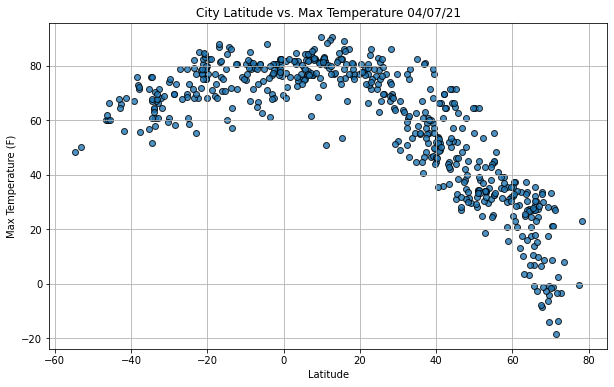

In [13]:
# Import time module
import time

# Build the scatter plot for latitude vs. max temperature.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            max_temps,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Max Temperature "+ time.strftime("%x"))
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure.
plt.savefig("weather_data/Fig1.png")

# Show plot.
plt.show()

# Latitude vs. Humidity scatter plot

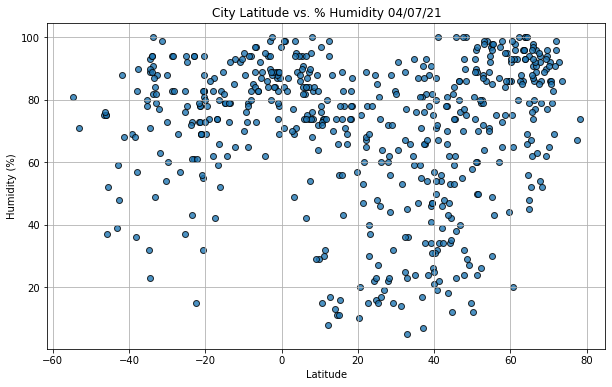

In [14]:
# Build the scatter plots for latitude vs. humidity.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            humidity,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. % Humidity "+ time.strftime("%x"))
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig2.png")
# Show plot.
plt.show()

# Latitude vs. Cloudiness scatter plot

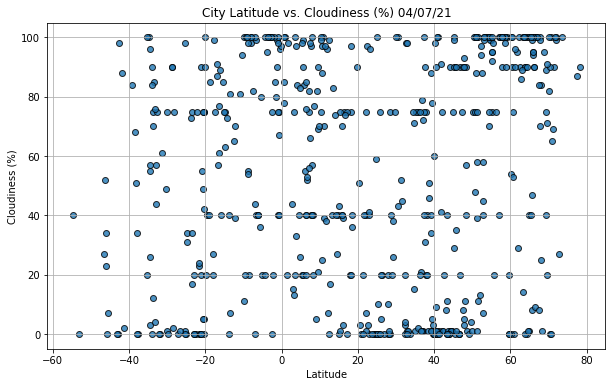

In [15]:
# Build the scatter plots for latitude vs. cloudiness.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            cloudiness,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Cloudiness (%) "+ time.strftime("%x"))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig3.png")
# Show plot.
plt.show()

# Latitude vs. Wind Speed scatter plot

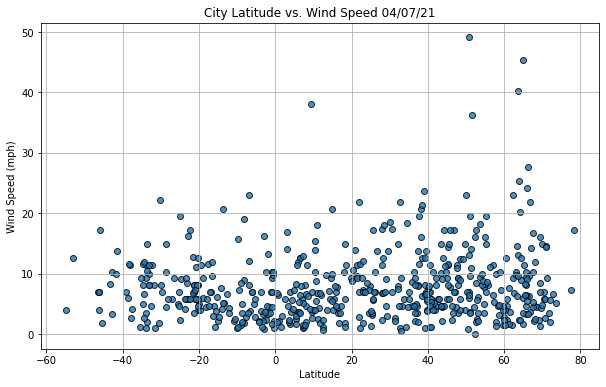

In [16]:
# Build the scatter plots for latitude vs. wind speed.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            wind_speed,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Wind Speed "+ time.strftime("%x"))
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig4.png")
# Show plot.
plt.show()

In [17]:
# Create a function to create perform linear regression on the weather data
# and plot a regression line and the equation with the data.
def plot_linear_regression(x_values, y_values, title, y_label, text_coordinates, figpath=None):
    # Run regression on hemisphere weather data.
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
    print("slope=" + str(slope))
    print("intercept=" + str(intercept))
    print("r_value=" + str(r_value))
    print("p_value=" + str(p_value))
    print("std_err=" + str(std_err))
    
    # Calculate the regression line "y values" from the slope and intercept.
    regress_values = x_values * slope + intercept
    # Get the equation of the line.
    #line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) + " r=" + str(round(r_value,2)) + " p=" + str(round(p_value,2)) + " stderr=" + str(round(std_err,2))
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Create a scatter plot and plot the regression line.
    plt.subplots(figsize=(10, 6))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r")
    # Annotate the text for the line equation.
    plt.annotate(line_eq, text_coordinates, fontsize=15, color="red")
    plt.title(title)
    plt.xlabel('Latitude')
    plt.ylabel(y_label)
    plt.savefig(figpath)
    plt.show()

In [18]:
index13 = city_data_df.loc[13]
index13

City                       Kodiak
Country                        US
Date          2021-04-07 23:39:25
Lat                         57.79
Lng                      -152.407
Max Temp                     39.2
Humidity                       65
Cloudiness                     90
Wind Speed                   9.95
Name: 13, dtype: object

# Create northern_hemi_df and souther_hemi_df

In [19]:
northern_hemi_df = city_data_df.loc[(city_data_df["Lat"] >= 0)]
southern_hemi_df = city_data_df.loc[(city_data_df["Lat"] < 0)]

# Linear regression on Northern Max Temp

slope=-1.080492491007094
intercept=93.82702423704663
r_value=-0.8951772012371648
p_value=1.2065096203109864e-139
std_err=0.02717205555624124


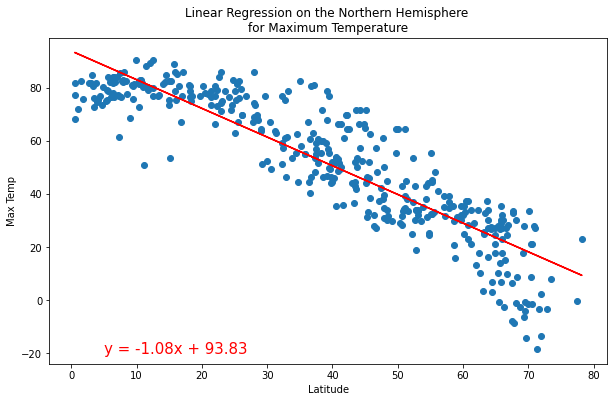

In [20]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Max Temp"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor Maximum Temperature',
                       'Max Temp',
                       (5,-20),
                       "weather_data/temp_vs_lat_north.png")

# Linear regression on Southern Max Temp

slope=0.36733706654778103
intercept=80.11452772065566
r_value=0.582363712156249
p_value=2.309503412080761e-16
std_err=0.040163256281305876


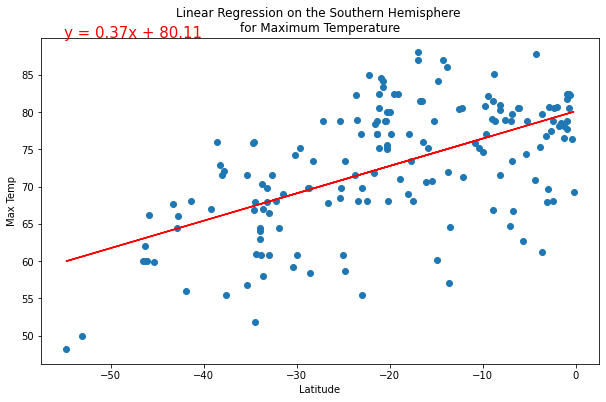

In [21]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Max Temp"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor Maximum Temperature',
                       'Max Temp',
                       (-55,90),
                       "weather_data/temp_vs_lat_south.png")

# Linear regression on Northern Humidity

slope=0.21912163669399481
intercept=59.691415228814634
r_value=0.1837569878241126
p_value=0.00024526197294663464
std_err=0.0592024094789788


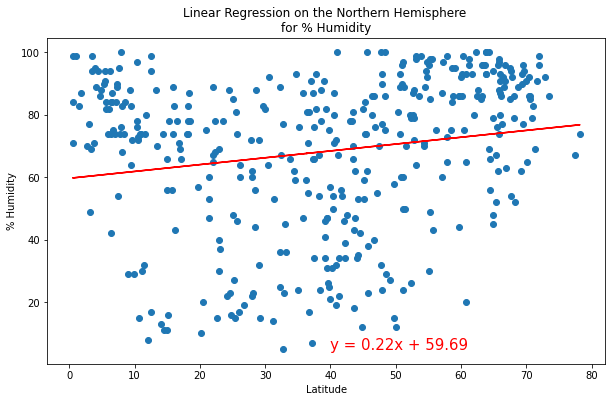

In [22]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Humidity"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor % Humidity',
                       '% Humidity',
                       (40,5),
                       "weather_data/hum_vs_lat_north.png")

# Linear regression on Southern Humidity

slope=0.400676598560939
intercept=85.16480418936075
r_value=0.3336122990254318
p_value=1.1930074587627932e-05
std_err=0.08868218920748175


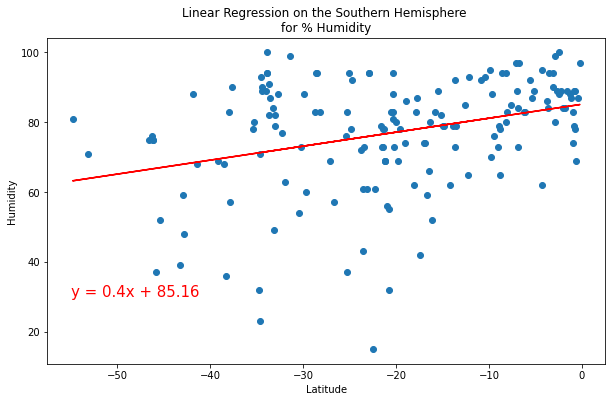

In [23]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Humidity"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor % Humidity',
                       'Humidity',
                       (-55, 30),
                      "weather_data/hum_vs_lat_south.png")

# Linear regression on Northern Cloudiness

slope=0.34441222063087823
intercept=39.52146435197829
r_value=0.18372788376533528
p_value=0.0002458291579308175
std_err=0.09306874685925776


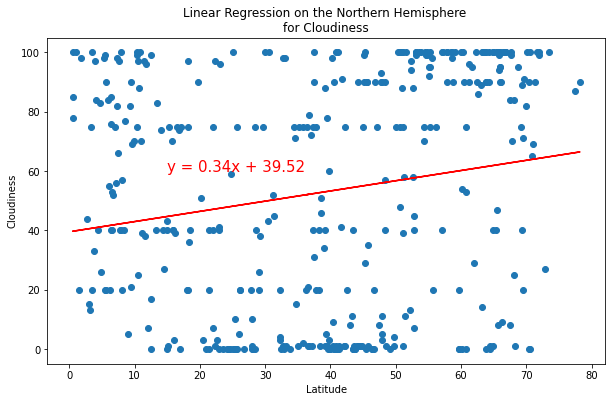

In [24]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Cloudiness"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor Cloudiness',
                       'Cloudiness',
                       (15,60),
                      "weather_data/clouds_vs_lat_north.png")

# Linear regression on Southern Cloudiness

slope=1.0091876937015536
intercept=73.16632082085292
r_value=0.3677823687431216
p_value=1.1752869195403798e-06
std_err=0.19986145299481142


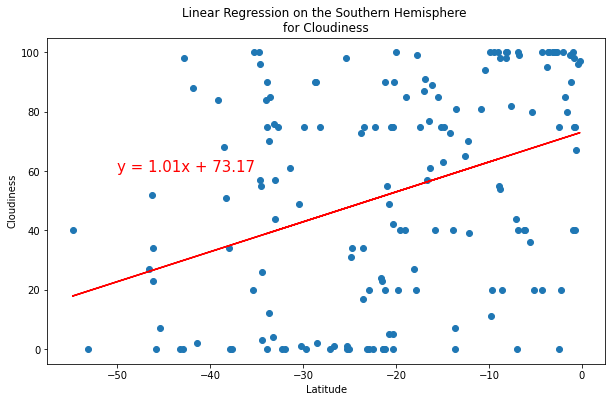

In [25]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Cloudiness"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor Cloudiness',
                       'Cloudiness',
                       (-50,60),
                      "weather_data/clouds_vs_lat_south.png")

# Linear regression on Northern Wind Speed

slope=0.04058513802072277
intercept=6.594560686772375
r_value=0.13217250108667977
p_value=0.008620537465795162
std_err=0.015372903126162598


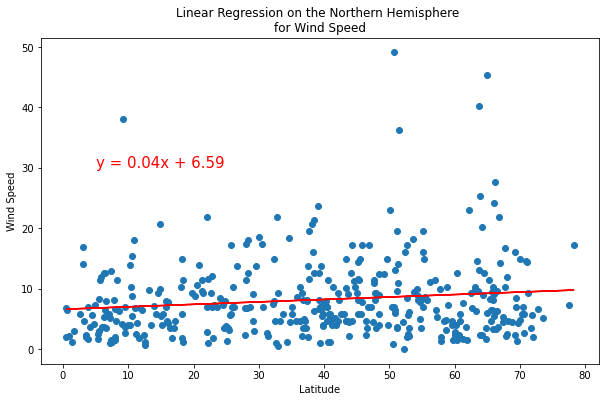

In [26]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Wind Speed"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor Wind Speed',
                       'Wind Speed',
                       (5, 30),
                       "weather_data/wind_vs_lat_north.png")

# Linear regression on Southern Wind Speed

slope=-0.059353777890653034
intercept=5.813762813566384
r_value=-0.17659606607418044
p_value=0.023266153096328655
std_err=0.025911568624516296


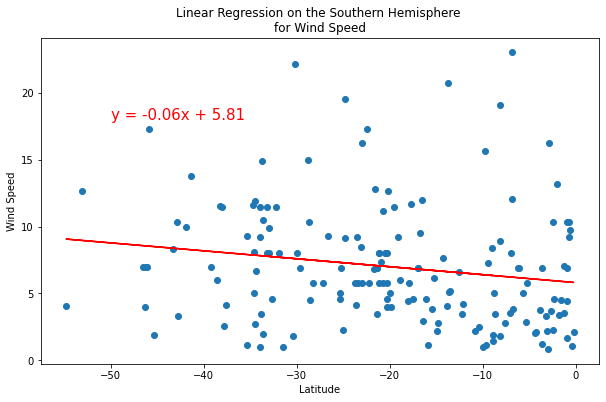

In [27]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Wind Speed"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor Wind Speed',
                       'Wind Speed',
                       (-50,18),
                      "weather_data/wind_vs_lat_south.png")